# A/B-тестирование

### Цель

Провести оценку результатов A/B-теста. В нашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.

- Оцените корректность проведения теста
- Проанализируйте результаты теста

### Задачи

- проверить пересечение тестовой аудитории с конкурирующим тестом,
- проверить совпадение теста и маркетинговых событий, другие проблемы временных границ теста.

### Техническое задание

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.
    


### Описание данных

`ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год.

Структура файла:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

`final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

`final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время события;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

`final_ab_participants.csv` — таблица участников тестов.

Структура файла:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

## 1. Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import math as mth
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import datetime as dt
import plotly.express as px
import plotly.graph_objs as go
from pandas.plotting import register_matplotlib_converters
import warnings
# конвертеры, которые позволяют использовать типы pandas в matplotlib  
register_matplotlib_converters()
pd.options.display.float_format = '{:,.2f}'.format
import warnings
warnings.filterwarnings('ignore')

In [2]:
test_participants = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_participants.csv') 
users = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_new_users.csv') 
events = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_events.csv') 
marketing_events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_project_marketing_events.csv')

In [3]:
def first_info(df):
    display(df.head(5))
    df.info()
    display(df.describe())
    print ('Количество дубликатов -', df.duplicated().sum())
    print("Сумма пропусков по столбцам")
    display(df.isna().sum())
    return df

In [4]:
test_participants_info = first_info(test_participants)

Проверим уникальные значения столбцов group и ab_test

In [5]:
test_participants['ab_test'].unique()

Разница с тех заданием: - в датасете содержатся данные еще об одном тесте interface_eu_test

In [6]:
test_participants['group'].unique()

группы: А — контрольная, B — новая платёжная воронка - соответствует тех заданию

In [7]:
test_participants['group'].value_counts()

In [8]:
users_info = first_info(users)

Приведем тип столбца first_date в соответствие, проверим уникальные значения столбцов region и device

In [9]:
users['first_date'] = pd.to_datetime(users['first_date'], format='%Y-%m-%d')

In [10]:
users['region'].unique()

In [11]:
users['device'].unique()

In [12]:
events_info = first_info(events)

In [13]:
events['event_dt'] = pd.to_datetime(events['event_dt'], format='%Y-%m-%d %H:%M:%S')

In [14]:
events['event_name'].unique()

In [15]:
events['event_name'].value_counts()

дата остановки: 2021-01-04;

Количество заполненных данных в столбце details = количеству событий purchase (покупок), осталыные столбцы это вход, карточка продукта и корзина т.е. пропуски логичны и их не нужно обрабатывать        

In [16]:
marketing_events_info = first_info(marketing_events)

In [17]:
marketing_events['name'].unique()

In [18]:
marketing_events['regions'].unique()

In [19]:
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'], format='%Y-%m-%d')
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'], format='%Y-%m-%d')

__ВЫВОДЫ:__

+ импортированы библиотеки для дальнейшей работы с данными
+ выведена первичная информация о датасетах (основная информация, пропуски и дубликаты)
+ проверены уникальные значения датасетов (события, группы, регионы, устройства, тесты)
+ столбцы с датами приведены в соответствие
+ изучена природа пропусков и, в результате, оставлены пропуски в столбце details 


## 2. Корректность проведения теста

### Соответствие данных требованиям технического задания

### Техническое задание

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.
    

__При проверке уникальных значений мы уже установили, что в датасете содержится информация о 2х тестах:__
+ recommender_system_test
+ interface_eu_test

__Также при проверке уникальных значений мы подтвердили, что данные имеются по 2м группам : А и В__

In [20]:
users['first_date'].describe()

_Не соответствует тех заданию:_


+ дата запуска совпадает с заявленной: 2020-12-07
+ дата остановки набора новых пользователей: по ТЗ = 2020-12-21 / в датасете = 2020-12-23


In [21]:
difference_test = test_participants.merge(users, on = 'user_id', how='left')
difference_test = difference_test.query('ab_test == "recommender_system_test"')
difference_test['first_date'].describe()

__Удалим не соответствующие ТЗ данные__

In [22]:
right_users = users.query("first_date <= '2020-12-21'")

In [23]:
print('Осталось {} пользователей, удалено {} пользователей ({:.2f} %)'.format(
    right_users['user_id'].nunique(), users['user_id'].nunique() - right_users['user_id'].nunique(), 
    100 - right_users['user_id'].nunique() / users['user_id'].nunique()*100))

In [24]:
events['event_dt'].describe()

_Не соответствует тех заданию:_

+ дата запуска совпадает с заявленной: 2020-12-07
+ дата остановки: по ТЗ =  2021-01-04 / в датасете = 2020-12-30 

_нет данных по 5 дням с 31 декабря по 4 января_

In [25]:
marketing_events.query('start_dt <= "2021-01-04" and finish_dt >= "2020-12-07"')

__В период проведения теста 25 декабря была запущена рождественская/новогодня промоакция и 30 января новогодняя лотерея. Т.к. рождественская/новогодня промоакция была проведена в регионах EU, N.America  она могла отразиться на действиях пользователей и исказить результаты теста. В новогодней лотерее европейские пользователи участие не принимали, т.е. данная акция не повлияла на результаты теста__

__Пересечение пользователей__

In [26]:
test_participants['ab_test'].value_counts()

In [27]:
test_participants[test_participants.duplicated(subset=['user_id'], keep=False) == True]['ab_test'].value_counts()

__1602 пользователя участвуют одновременно в 2х тестах__

In [28]:
test_participants.query('ab_test == "recommender_system_test"')['group'].value_counts()

Разделение на группы неравномерное, разница почти в 1000 человек.

__Выведем таблицу с пользователями, которые участвовали в нескольких тестах одной из групп__

In [29]:
repeat_users = test_participants.groupby(['user_id', 'group']).size().reset_index()
repeat_users.columns = ['user_id', 'group', 'count']
repeat_users = repeat_users.query("count>1").sort_values(by='user_id')
repeat_users

__Посмотрим результаты по айди пользователй групп А и В__

In [30]:
test_participants.query("user_id == '001064FEAAB631A1'")

In [31]:
test_participants.query("user_id == '00341D8401F0F665'")

In [32]:
print('Количество пользователей, которые участвовали в нескольких тестах одной из групп составляет {} шт.'.format(
    len(repeat_users)))

__Т.к. нас интересуют только пользователи из recommender_system_test, данные пользователи не повлияют на дальнейшее исследование, оставим без изменений.__

__Проверим также повторных пользователей для теста заявленного в ТЗ__

In [33]:
participants = test_participants.query('ab_test == "recommender_system_test"')

In [34]:
repeat_users_test = participants.groupby(['user_id', 'group']).size().reset_index()
repeat_users_test.columns = ['user_id', 'group', 'count']
repeat_users_test = repeat_users_test.query('count>1').sort_values(by='user_id')
repeat_users_test.head()

В группах A и B  теста из ТЗ нет одинаковых пользователей.

Обьединим таблицу с событиями и и отфильтрованными участниками

In [35]:
test_recommender = participants.merge(events, on = 'user_id', how='left')
test_recommender.head(5)

In [36]:
test_recommender.isna().sum()

In [37]:
test_recommender.info()

_После обьединения выявились 3026 пользователей, которые не совершали никаких действий. Данные пользователи при дальнейшем исследовании будут "засорять" данные, удалим такие строки_ 

In [38]:
test_recommender = test_recommender.dropna(subset=['event_name'])
test_recommender.info()

__Обьеденим таблицу с таблицей пользователей__

In [39]:
test_recommender = test_recommender.merge(right_users, on = 'user_id', how='left')
test_recommender.head(5)

Удалим пользователей не из Европы

In [40]:
test_recommender['region'].value_counts()

In [41]:
test_recommender = test_recommender.query("region == 'EU'")

In [42]:
test_recommender.info()

In [43]:
test_recommender['group'].value_counts()

In [44]:
test_recommender.groupby('group')['user_id'].nunique()

_Количество пользователей неравномерно распределено по группам, в группе А в 3 раза больше пользователей_

__Удалим из таблицы все события, которые длились дольше 14 дней__

In [45]:
test_recommender = (test_recommender.drop(
    test_recommender[test_recommender['event_dt'] >= (test_recommender['first_date'] + pd.Timedelta(14, 'D'))].index))

In [46]:
test_recommender.info()

Проверка удовлетворение условию ТЗ "аудитория: 15% новых пользователей из региона EU"

In [47]:
participants = participants.merge(right_users, on='user_id', how = 'inner')
participants.head(5)

In [48]:
participants.query('region == "EU"')['user_id'].nunique()

In [49]:
right_users.query('region == "EU"')['user_id'].nunique()


In [50]:
print('Аудитория из EU в тесте "recommender_system_test" = {:.2f} %'.format(
    participants.query('region == "EU"')['user_id'].nunique() / right_users.query(
        'region == "EU"')['user_id'].nunique()*100))

Аудитория из Европы соответствует ТЗ и равна 15%

__ВЫВОДЫ:__

При проверке данных на соответствие ТЗ установленно:


+ количество тестов 2, оставлен только соответствующий ТЗ recommender_system_test
+ Дата запуска и остановки набора пользователей в рамках нашего теста соответствует ТЗ
+ Дата остановки теста не соответствует заявленой ТЗ. Не хватает 5 дней (возможно техническая ошибка при выгрузке данных)
+ На результаты теста могла повлиять рождественская промоакция. Это могло отразиться на действиях пользователей, а следовательно - исказить результаты теста.
+ Фактическое число участников (6701) немного превышает заявленные в ТЗ (6000), но если убрать из анализа пользователей, пересекающихся с другим тестом, их будет меньше необходимого. Принято решение оставить пересечение.
+ Количество пользователей в группах теста распределены не равномерно - после фильтрации, в группе А 2604 пользователя, а в группе В 877 пользователей, что в 3 раза меньше. Такая неравномерность приведет к искальжению результатов в сторону группы А.
+ аудитория в 15% новых пользователей из Европы соответствует ТЗ,но в тест попали пользователи из других стран, а не только из Eвропы (пользователи из других регионов удалены)

_Теста проеведен некорректно_

## 3. Исследовательский анализ данных

### Количество событий на пользователя одинаково распределены в выборках?

In [51]:
events_user = test_recommender.groupby('user_id')['event_name'].count().reset_index()
events_user.columns = ['user_id', 'count_events']
events_user

In [52]:
test_recommender = test_recommender.merge(events_user, how='left', on='user_id')
test_recommender

In [53]:
test_recommender['e_date'] = test_recommender['event_dt'].dt.date

In [54]:
a_test = test_recommender.query("group == 'A'")
b_test = test_recommender.query("group == 'B'")

In [55]:
a_test.describe()

In [56]:
b_test.describe()

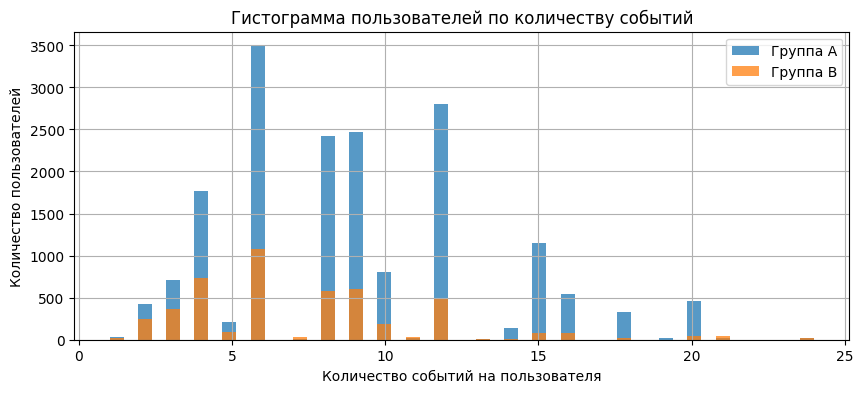

In [57]:
a_test['count_events'].hist(bins=50, figsize=(10,4), label='Группа A', alpha=0.75)
b_test['count_events'].hist(bins=50, figsize=(10,4), label='Группа B', alpha=0.75)
plt.legend()
plt.xlabel('Количество событий на пользователя')
plt.ylabel('Количество пользователей')
plt.title('Гистограмма пользователей по количеству событий')
plt.show()

Распределения схожи, но количество пользователей в группе А больше, и в среднем в группе A совершают на 1 действие больше, чем в группе B - 8,97 против 7,39.

### Как число событий в выборках распределено по дням?

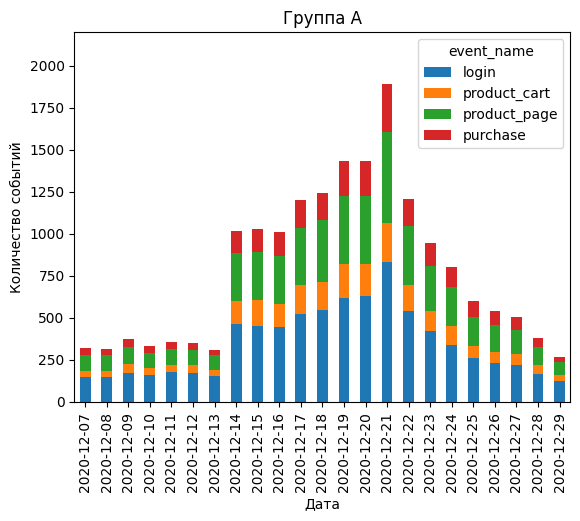

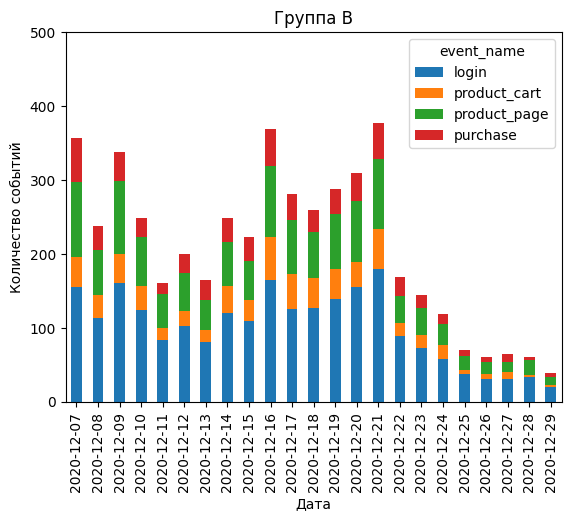

In [58]:
fig = plt.figure(figsize=(10,4))

ax = a_test.pivot_table(
    index='e_date', values='user_id', columns='event_name', aggfunc='count').plot.bar(stacked=True, ylim=(0, 2200))
ax.set_title("Группа A")
ax.set_xlabel("Дата")
ax.set_ylabel("Количество событий")
ax = b_test.pivot_table(
    index='e_date', values='user_id', columns='event_name', aggfunc='count').plot.bar(stacked=True, ylim=(0, 500))
ax.set_title("Группа B")
ax.set_xlabel("Дата")
ax.set_ylabel("Количество событий")
plt.show()

+ Из графиков видно что рожденственское промо не повлияло на активность пользователей
+ Группы ведут себя по разному:
  + у группы А количество событий возрастает в середине исследуемого периода, пик 21 декабря
  + у группы Б количество событий больше в начале и середине исследования
+ максимальная активность в 2х группах приходится на 21 декабря
+ с 22 декабря у обеих груп идет спад количества событий

### Как меняется конверсия в воронке в выборках на разных этапах?

In [59]:
test_recommender_count = test_recommender.groupby(['group', 'event_name'], as_index=False) \
    .agg({'user_id':'nunique'}) \
    .rename(columns={'user_id':'users_count'}).reindex([0, 2, 1, 3, 4, 6, 5, 7])
# cтроки переиндексированы для правильного посроения воронки
test_recommender_count

In [60]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'Группа А',
    y = test_recommender_count.query('group == "A"')['event_name'],
    x = test_recommender_count.query('group == "A"')['users_count'],
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = 'Группа B',
    y = test_recommender_count.query('group == "B"')['event_name'],
    x = test_recommender_count.query('group == "B"')['users_count'],
    textinfo = "value+percent initial"))

fig.update_layout(
    title="Воронка событий по группам",
    width=1000, 
    height=500,
)

fig.show()

+ Около 1/3 пользователей теряются при переходе к просмотру карточки товара в группе А и почти половина в группе В
+ Примерно половина от посмотревших карточку товара, переходит в корзину в обеих группах
+ ! Оплатить товар можно, не заходя в корзину
+ Между предпоследним и последним этапом конверсия практически стопроцентная
+ B воронках не видно ожидаемого улучшения в 10% на каждом шаге воронки.

### 4.  A/B-тестированиe

In [61]:
test_with_persent = test_recommender.pivot_table(
    index='event_name', 
    columns='group', 
    values='user_id',
    aggfunc='nunique').reset_index()
test_with_persent = test_with_persent.reindex([0, 2, 1, 3]).reset_index()
test_with_persent = test_with_persent.drop(columns=['index'], axis=1)
test_with_persent['step_%_A'] =  (test_with_persent['A'].pct_change()*100)
test_with_persent.loc[0, 'step_%_A'] = 100
test_with_persent['step_%_B'] =  (test_with_persent['B'].pct_change()*100)
test_with_persent.loc[0, 'step_%_B'] = 100
test_with_persent

Улучшение каждой метрики не менее, чем на 10% не произошло

In [62]:
test = test_recommender.pivot_table(
    index='event_name', 
    columns='group', 
    values='user_id',
    aggfunc='nunique').reset_index()
test = test.reindex([0, 2, 1, 3]).reset_index()
test = test.drop(columns=['index'], axis=1)
test = test.set_index(test.columns[0])
test

In [63]:
users_group = test_recommender.groupby('group')['user_id'].nunique().reset_index()
users_group = users_group.set_index(users_group.columns[0])
users_group

__Выдвигаем гипотезы:__


+ H_0 = доли посетителей побывавших на этапе воронки равны

+ H_1 = между долями уникальных посетителей побывавших на этапе воронки есть значимая разница

In [64]:
def z_test(group_1, group_2, event_name, alpha): 
    p1_ev = test.loc[event_name, group_1]
    p2_ev = test.loc[event_name, group_2]
    
    p1_us = users_group.loc[group_1, 'user_id']  
    p2_us = users_group.loc[group_2, 'user_id'] 
    
    p1 = p1_ev / p1_us
    p2 = p2_ev / p2_us
    difference = p1 - p2
    p_combined = (p1_ev + p2_ev) / (p1_us + p2_us)
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/p1_us + 1/p2_us))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    bonferroni = alpha / 4 # количество проведенных тестов
    print('Проверка групп {} и {}, для события "{}": p-значение = {p_value:.2f}'.format(
        group_1, group_2, event_name, p_value=p_value))
    if p_value < bonferroni:
        print(
            'Отвергаем нулевую гипотезу: между долями уникальных посетителей побывавших на этапе воронки есть значимая разница'
        )
    else:
        print('Не получилось отвергнуть нулевую гипотезу, доли посетителей, побывавших на этапе воронки, одинаковы')

In [65]:
for event_name in test.index:
    z_test('A', 'B', event_name, 0.05)
    print()

__Выводы:__

Проведена оценка статистической разницы долей двух групп по z-критерию по каждому событию::

+ Авторизация (login) -  доли посетителей, побывавших на этапе воронки, равны
+ Просмотр карточки товара (product_page) - доли посетителей, побывавших на этапе воронки, неравны
+ Просмотр корзины (product_cart) - доли посетителей, побывавших на этапе воронки, равны
+ Покупка (purchase) - доли посетителей, побывавших на этапе воронки, равны

## Общие выводы

__Проведение теста не соответсвует техническому заданию:__


+ Количество тестов 2, оставлен только соответствующий ТЗ recommender_system_test
+ Дата запуска соответствует ТЗ, дата остановки в рамках нашего теста соответствует ТЗ
+ Дата остановки теста не соответствует заявленой ТЗ. Не хватает 5 дней (возможно техническая ошибка при выгрузке данных)
+ На результаты теста могла повлиять рождественская промоакция. Это могло отразиться на действиях пользователей, а следовательно - исказить результаты теста.
+ Фактическое число участников (6701) немного превышает заявленные в ТЗ (6000), но если убрать из анализа пользователей, пересекающихся с другим тестом, их будет меньше необходимого. Принято решение оставить пересечение.
+ Количество пользователей в группах теста распределены не равномерно - после фильтрации, в группе А 2604 пользователя, а в группе В 877 пользователей, что в 3 раза меньше. Такая неравномерность приведет к искажению результатов в сторону группы А.
+ Аудитория в 15% новых пользователей из Европы соответствует ТЗ,но в тест попали пользователи из других стран, а не только из Eвропы (пользователи из других регионов удалены)
+ Вместо ожидаемого улучшения метрик группы В на 10% наблюдается их снижение  Стоит отметить, что практически все пользователи с этапа просмотра корзины производят покупку.
_Тест проеведен некорректно_


__A/B-тест:__

+ С учетом допущенных ошибок при проведении теста, по его результатам можно оценить отсутсвие ожидаемого эффекта в качестве прироста конверсии по просмотру карточек в размере 10%. Согласно воронке конверсии событий группа В имеет показатели ниже контрольной группы А. У product_cart и purchase статистически значимая разница отсутствует, поэтому внедрение улучшенной рекомендательной системы нельзя назвать успешным.

__Рекомендации:__

+ приостановить внедрение улучшенной рекомендательной системы;
+ исправить все несоответствия техническому заданию, и перезапустить его.
+ запускать новый тест рекомендуется уже после завершения всех маркетинговых событий.